# Cost function features and VQE

This notebook showcases the more advanced features of our cost functions using the example of VQE. Since QAOA can be thought of as a special case of VQE, everything said here applies also to the QAOA cost functions, unless otherwise explicitly mentioned.

### Contents
0. [Setting up VQE](#setup)
1. [Simulating sampling noise](#nshots)
2. [Getting the measurement variance](#scalar_cost_function)
3. [Logging of the optimization process](#enable_logging)
4. [Running on the QVM or QPU](#on_qvm)
5. [Using other optimisers](#other_optimisers)
6. [Towards QAOA](#towards_qaoa)
7. [Appendix: Simulated measurement noise - statistics implementation details](#statistics_details)

As with all the Demo Notebooks, you need to start the Simulator and the Quil Compiler in the background by typing `qvm -S` and `quilc -S` in two open and disposable terminal windows.

## Short Intro: The Variational Quantum Eigensolver (VQE)

We begin with a short introduction to the VQE to establish nomenclature. The aim of VQE is to find the ground state and/or ground state energy of a given cost hamiltonian $\hat{H}_\mathrm{cost}$. To do so, one prepares a trial state $\left| \psi (\vec{\gamma})\right> = \hat{U}(\vec{\gamma}) \left| 0 \right>$ by applying a parametric program $\hat{U}(\vec{\gamma})$ to the initial state $\left| 0 \right>$, and then measures its energy expectation value with respect to the cost Hamiltonian, $\left<\hat{H}_\mathrm{cost}\right>(\vec{\gamma}) = \left< \psi(\vec{\gamma}) \right|\hat{H}\left| \psi(\vec{\gamma})\right>$. This expectation value is then minimized by optimizing the parameters $\vec{\gamma}$ in a classical optimizer until a minimum of $\left<\hat{H}_\mathrm{cost}\right>(\vec{\gamma})$ is found for a parameter set $\vec{\gamma}^*$. The lowest energy eigenstate of $\hat{H_\mathrm{cost}}$ can now be prepared by applying $\hat{U}(\vec{\gamma}^*)$ to $\left| 0 \right>$, and its energy is given by $E_0 = \left< \psi(\vec{\gamma}^*) \right|\hat{H}_\mathrm{cost}\left| \psi(\vec{\gamma}^*)\right>$

Now it should also be clear, that QAOA can be considered as a special case of VQE where the Ansatz is fixed to be of the form

$$
\hat{U}(\vec{\beta}, \vec{\gamma})
    = e^{-i \beta_p H_M} e^{-i \gamma_p H_C}
      \cdots
      e^{-i \beta_0 H_M} e^{-i \gamma_1 H_C}
$$

with the free parameters $\vec{\beta}, \vec{\gamma}$.

Before we begin, let us first import all neccesary libraries:

In [1]:
# The usual combination of scipy, numpy and matplotlib
from scipy.optimize import minimize
import numpy as np
import matplotlib.pyplot as plt

# The pyquil dependencies
from pyquil.paulis import PauliSum, PauliTerm
from pyquil.api import WavefunctionSimulator, get_qc
from pyquil.quil import Program
from pyquil.gates import RY, H
from pyquil.unitary_tools import lifted_pauli

# A finally the cost functions
from entropica_qaoa.vqe.cost_function import (PrepareAndMeasureOnWFSim,
                                              PrepareAndMeasureOnQVM,
                                              pauli_matrix)
from entropica_qaoa.qaoa.cost_function import QAOACostFunctionOnWFSim

# And one our QAOA parameter classes
from entropica_qaoa.qaoa.parameters import StandardParams, FourierParams

import warnings
warnings.filterwarnings('ignore')

<a id='setup'></a>

## Setting up the problem

We start by creating a cost hamiltonian `hamiltonian` and state preparation program `prepare_ansatz`. For demonstration purposes we will use the simplest possible problem for VQE:  the hamiltonian is the bit-flip operator $X$ (Pauli operator $\sigma_X$) on a single qubit, and the parametric program consists of a single $R_y$-rotation. The parameter $\gamma$ is the rotation angle of this rotation.


**Note**

Besides an `RY` gate, we also need to add a `declare` instruction to `prepare_ansatz` to declare a classical memory register. Later the rotation angle `gamma` will be written (by the user/optimiser) and read (by the WavefunctionSimulaor/QVM) from this register.
This design allows our VQE and QAOA cost functions to make use of Quil's [parametric compilation](http://docs.rigetti.com/en/latest/basics.html?programs#parametric-compilation), and we don't have to recompile the program every time we update the parameters.

In [2]:
# create the cost hamiltonian
hamiltonian = PauliSum([PauliTerm("X", 0)])

# and the parametric state preparation program:
prepare_ansatz = Program() # builds an empty program
params = prepare_ansatz.declare("params", # add a classical register to store the values in 
                                memory_type="REAL", memory_size=1)
#prepare_ansatz.inst(H(0))
prepare_ansatz.inst(RY(params[0], 0))

print("The hamiltonian\n"
      "---------------\n", hamiltonian)

print("\nThe program\n"
      "-----------\n", prepare_ansatz)

The hamiltonian
---------------
 (1+0j)*X0

The program
-----------
 DECLARE params REAL[1]
RY(params[0]) 0



Next we can create a cost function to be passed to a classical optimizer later. We do this using `vqe.cost_function.PrepareAndMeasureOnWFSim`, a class that combines a cost hamiltonian `hamiltonian` and a state preparation circuit `prepare_ansatz`. This cost function can subsequently be passed to any classical optimizer - here we will use methods available in `scipy.optimize.minimize`.

In [3]:
# create the cost_function with our ansatz and hamiltonian:
cost_fun = PrepareAndMeasureOnWFSim(prepare_ansatz=prepare_ansatz,
                                    make_memory_map=lambda p: {"params": p},
                                    hamiltonian=hamiltonian)

With the cost function set up, let us have a look at it graphically:

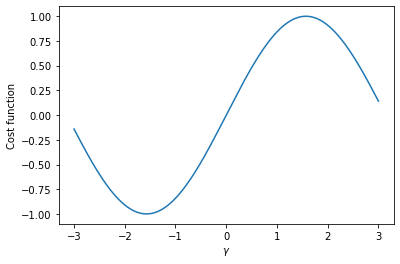

In [4]:
gammas = np.linspace(-3,3,200)
exp_vals = np.empty_like(gammas)
for i, v in enumerate(gammas):
    exp_vals[i] = cost_fun([v])
    
plt.plot(gammas, exp_vals)
plt.xlabel(r"$\gamma$")
plt.ylabel("Cost function")
plt.show()

We can also find the minimal function value and argument:

In [5]:
# the initial argument
gamma0 = [0]
# and minimization
out = minimize(cost_fun, gamma0, method="Cobyla")
print(out)

     fun: -0.9999999954355244
   maxcv: 0.0
 message: 'Optimization terminated successfully.'
    nfev: 24
  status: 1
 success: True
       x: array([-1.57070078])


**Aside: Interpretation for the interested reader** 

The plot above can be interpreted as follows. The qubit starts in the state $|0\rangle$, and the operator $RY(\gamma)$ rotates its Bloch vector about the Y-axis through an angle $\gamma$. For $\gamma = 0$ the qubit remains in $|0\rangle$, which is an eigenstate of the Pauli $Z$ operator, and therefore the expectation value of the cost function $X$ is zero. For $\gamma = \pm\pi$, we flip the qubit to the state $|1\rangle$, which is again an eigenstate of the $Z$ operator, and thus has zero expectation value in the $x$-basis. When $\gamma = \pm \pi/2$, we create the superposition states $|\pm\rangle = (|0\rangle \pm |1\rangle)/\sqrt{2}$, which are eigenstates of the $X$ operator, and we therefore find the maximum and minimum values of the cost function, $\pm 1$.

The result `out` should now contain the minimal eigenvalue of `hamiltonian` as the minimum function value, and the correct parameters for `prepare_ansatz` to prepare the corresponding eigenstate. We can compare this with the real minimum eigenvalue, by printing `hamiltonian` as a matrix:

In [6]:
print("The output of scipy.optimize.minimize:\n",out)
print("\n And the eigenvalues of the hamiltonian:\n", np.linalg.eigvalsh(pauli_matrix(hamiltonian)))

The output of scipy.optimize.minimize:
      fun: -0.9999999954355244
   maxcv: 0.0
 message: 'Optimization terminated successfully.'
    nfev: 24
  status: 1
 success: True
       x: array([-1.57070078])

 And the eigenvalues of the hamiltonian:
 [-1.  1.]


This looks good - it seems we found the ground state almost exactly. On a real quantum computer, however, we can't measure the expectation value of a state directly. Instead, we have to take multiple samples, and calculate the mean of the resulting output values. The more samples we take from the output state, the closer the sample mean of the ground state energy will come to its true mean. We can think of the effect of taking only a finite number of samples as adding uncertainty, or noise, to the true underlying probability distribution. 

In practice, if we have only an estimate of the energy, but not its true value, this will influence the effectiveness of different optimisers. Gradient-based optimisers, for example, work well when we have exact function values, and we can compute gradients through finite differences to determine where to move in the next iteration. In the presence of noisy function value estimates, we may expect such methods to be less effective.

To effciently simulate the effect of this sampling noise, the `PrepareAndMeasureOnWFSim` has an argument `nshots` that we will demonstrate in the following section.

<a id='nshots'></a>

## Simulating sampling noise

To see how this sampling noise influences the behaviour of different optimisers, we provide the `nshots` option in the Wavefunction Simulator cost function `PrepareAndMeasureOnWFSim`. If we set `nshots=N` in either the cost function constructor or the cost function call, it will return the true expectation value plus simulated sampling noise with the (approximate) statistics of the true noise at $N$ samples. Note the word "approximate" here: to speed up simulations, we use a Gaussian approximation of the noise, instead of actually taking $N$ samples. This works very well for large $N$ (where it also gives the largest speed up), but can lead to unphysical results for small $N$, such as expectation values lower than the actual minimum expectation value. More details on the implementation of this simulated sampling noise are given in the last section [below](#statistics_details).

[For clarity, note that if we are using the QVM or QPU and corresponding cost function `PrepareAndMeasureOnQVM`, the argument `nshots` is compulsory, and the noise is not mimicked using the Gaussian approximation - it is the true noise obtained by taking the specified finite number of samples.]

Let us now create a cost function that adds the simulated sampling noise for $N=1000$ shots, and also $N = 5$ shots.

In [7]:
# create the cost_function with our ansatz and hamiltonian:
cost_fun = PrepareAndMeasureOnWFSim(prepare_ansatz=prepare_ansatz,
                                    make_memory_map=lambda p: {"params": p},
                                    hamiltonian=hamiltonian,
                                    nshots = 1000)

In [8]:
gammas = np.linspace(-3,2,200)
exp_vals1 = np.empty_like(gammas)
for i, v in enumerate(gammas):
    exp_vals1[i] = cost_fun([v])

exp_vals2 = np.empty_like(gammas)
for i, v in enumerate(gammas):
    exp_vals2[i] = cost_fun([v], nshots=5) # Note: by passing in nshots here, we override the value of 1000 
                                           # from above

Now plot the outcomes side by side:

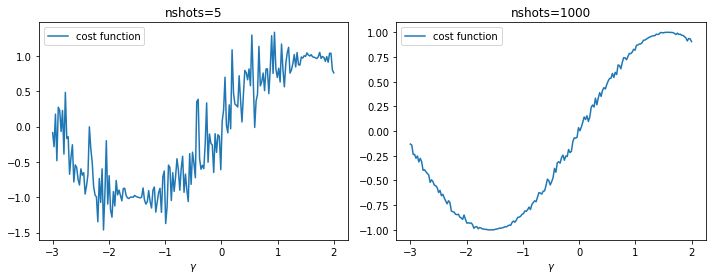

In [9]:
plt.figure(figsize=(10,4))

plt.subplot(121)
plt.plot(gammas, exp_vals2, label="cost function")
plt.title("nshots=5")
plt.legend()
plt.xlabel(r"$\gamma$")

plt.subplot(122)
plt.plot(gammas, exp_vals1, label="cost function")
plt.xlabel(r"$\gamma$")
plt.legend()
plt.title("nshots=1000")

plt.tight_layout()

In the left panel we see that when `nshots` is very small, we can observe unphysical results where the outcome is higher (lower) than the maximum (minimum) possible energy. This is because we are using a Gaussian approximation of the real sampling noise, which should only be valid when the number of shots is sufficiently large. In the right panel, we see that for a much larger value of `nshots`, the unphysical results are suppressed.

<a id='scalar_cost_function'></a>

## Getting the measurement variance

According to the central limit theorem, when `nshots` = $\infty$, the sample mean converges to the true mean (i.e. the mean obtained directly from the wavefunction), while the standard deviation of the sample mean tends to zero. For a finite value of `nshots`, the sample mean itself has a non-zero standard deviation. We can access this standard deviation by setting the flag `scalar_cost_function=False` in the constructor of the cost functions. The cost function then returns both the sample mean and its standard deviation.

As an implementation note, if we specify a sample size of `nshots=0`, no noise is added to the mean, and thus the standard deviation is also set to zero. This case is therefore equivalent to setting `nshots` = $\infty$.

Here is the above code again, with the flag `scalar_cost_function=False`:

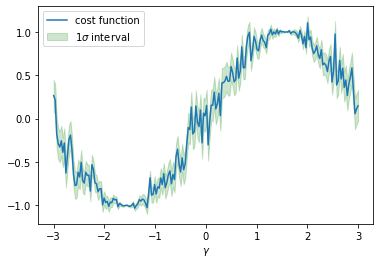

In [10]:
# create the cost_function with our ansatz and hamiltonian:
cost_fun = PrepareAndMeasureOnWFSim(prepare_ansatz=prepare_ansatz,
                                    make_memory_map=lambda p: {"params": p},
                                    hamiltonian=hamiltonian,
                                    nshots = 30,
                                    scalar_cost_function=False)

# get the means and standard deviations
gammas = np.linspace(-3,3,200)
exp_vals = np.empty_like(gammas)
std_devs = np.empty_like(gammas)
for i, v in enumerate(gammas):
    exp_vals[i], std_devs[i] = cost_fun([v])

# and plot both
plt.plot(gammas, exp_vals, label="cost function")
plt.fill_between(gammas, exp_vals - std_devs, exp_vals + std_devs,
                 label=r"$1\sigma$ interval", color='g',alpha=0.2)
plt.xlabel(r"$\gamma$")
plt.legend();

<a id='enable_logging'></a>

## Logging of the optimisation process

In the previous sections, we focused on single-shot measurements of the cost function. We now turn our attention to features that facilitate understanding of the process of cost function optimisation. For debugging and benchmarking purposes, it is often interesting to visualise how the optimisation progresses, and at which parameter values the cost function is called. We therefore provide the option to create a log of the cost function calls, `cost_function.log`. 

Since most typical optimisers (e.g. those contained in `scipy.optimize.minimze`) expect the objective function to return only a scalar value (the function value), and not a tuple (i.e. the value and standard deviation), we cannot use the same methods above to return the standard deviation; we must set `scalar_cost_function = True` (since this is the default value, we need not actually specify it). Instead, we will be able to access the standard deviation, as well as other information, through the optimiser log.

To create the optimisation log, we set `enable_logging=True`.

In [11]:
# create the cost_function with our ansatz and hamiltonian:
cost_fun = PrepareAndMeasureOnWFSim(prepare_ansatz=prepare_ansatz,
                                    make_memory_map=lambda p: {"params": p},
                                    hamiltonian=hamiltonian,
                                    nshots=100,
                                    enable_logging=True)

# and find the optimal value
gamma0 = [0]
# and minimization
out = minimize(cost_fun, gamma0, method="Cobyla")
print(out)

     fun: -0.995006044657827
   maxcv: 0.0
 message: 'Optimization terminated successfully.'
    nfev: 22
  status: 1
 success: True
       x: array([-1.59395])


We can examine the log as follows:

In [12]:
# extract gamma and function value for each of the function calls in the log
gamma_log = np.array([step.x for step in cost_fun.log])
fun_log = np.array([step.fun for step in cost_fun.log])

fun_log

array([[ 2.28877527e-03,  1.00000000e-01],
       [ 7.76303060e-01,  5.40302306e-02],
       [-8.38799676e-01,  5.40302306e-02],
       [-8.43648406e-01,  4.16146837e-02],
       [-7.33479054e-01,  8.01143616e-02],
       [-9.82648503e-01,  1.78246056e-02],
       [-9.90595774e-01,  7.07372017e-03],
       [-9.52429999e-01,  1.94547708e-02],
       [-1.00017983e+00,  8.29623162e-04],
       [-9.93486155e-01,  5.41771350e-03],
       [-1.00214305e+00,  2.29516577e-03],
       [-1.00105751e+00,  5.41771350e-03],
       [-9.99635602e-01,  3.85691044e-03],
       [-9.99537995e-01,  1.51405947e-03],
       [-1.00011529e+00,  2.68566936e-03],
       [-1.00042481e+00,  2.09990046e-03],
       [-9.95741235e-01,  2.39279518e-03],
       [-1.00024168e+00,  2.24635023e-03],
       [-9.97431599e-01,  2.31957333e-03],
       [-1.00111499e+00,  2.28516839e-03],
       [-1.00284175e+00,  2.30516312e-03],
       [-9.95006045e-01,  2.31516045e-03]])

Here, in each of the 22 function evaluations, we log the function value and its standard deviation. We can visualise this information, along with the parameter values at each function call:

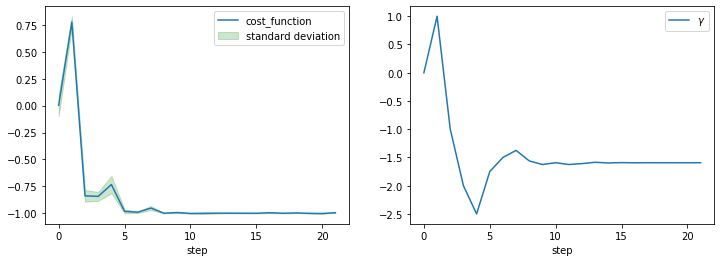

In [13]:
# create an array for the x-axis:
x = np.arange(out["nfev"])

fig, ax = plt.subplots(1,2, figsize=(12,4))
ax[0].plot(x, fun_log[:,0], label="cost_function")
ax[0].fill_between(x, fun_log[:,0] - fun_log[:,1], fun_log[:,0] + fun_log[:,1],
                   alpha=0.2, color='g',label="standard deviation")
ax[0].legend()
ax[0].set_xlabel("step")

ax[1].plot(x, gamma_log, label=r"$\gamma$")
ax[1].legend()
ax[1].set_xlabel("step");

<a id='on_qvm'></a>

## Running on the QVM or QPU

So far, we have run all our experiments on the Wavefunction Simulator. Eventually, however, we may also want to run them on the the QVM, or even the real QPU. Since these don't return a wavefunction, quantities of interest such as the energy expectation value and its standard deviation are determined by taking samples from the device. It is therefore essential to provide a value for the argument `nshots`, and we instead use the cost function constructors `PrepareAndMeasureOnQVM` (for general VQE) and `QAOACostFunctionOnQVM` (for QAOA). These behave mostly identically to `PrepareAndMeasureOnWFSim` and `QAOACostFunctionOnWFSim`, with a few differences:

 - We must pass an argument `qvm`, which is either an identification string for a QVM type
   such as `2q-qvm`, or a connection to a QVM or QPU (see [Rigetti's docs](http://docs.rigetti.com/en/latest/apidocs/quantum_computer.html)).

 - There is an additional argument `base_numshots`, which acts as a multiplier of `nshots`. This number is then hard-compiled into the circuit, whereas `nshots` can be changed dynamically during the optimisation (however, to do so would require writing a custom optimiser). This may be of interest for users working with more sophisticated optimisers. A more detailed explanation can be found in the FAQs section of the documentation.

We now walk through the above example again, only this time running on the QVM. As in [Simulating Sampling Noise](#nshots), we will calculate the cost function twice - once with 5 samples per point, and once with 1000 samples per point.

In [14]:
# this time we really need a QVM
qvm = get_qc("2q-qvm")

# sample 5 times
cost_fun = PrepareAndMeasureOnQVM(prepare_ansatz=prepare_ansatz,
                                  make_memory_map=lambda p: {"params": p},
                                  hamiltonian=hamiltonian,
                                  qvm = qvm,
                                  base_numshots = 5,
                                  nshots = 1,
                                  scalar_cost_function=False)

gammas = np.linspace(-3,3,200)
exp_vals1 = np.empty_like(gammas)
std_devs1 = np.empty_like(gammas)
for i, v in enumerate(gammas):
    exp_vals1[i], std_devs1[i] = cost_fun([v])
    
# sample 1000 times
cost_fun = PrepareAndMeasureOnQVM(prepare_ansatz=prepare_ansatz,
                                  make_memory_map=lambda p: {"params": p},
                                  hamiltonian=hamiltonian,
                                  qvm = qvm,
                                  base_numshots = 1000,
                                  nshots = 1,
                                  scalar_cost_function=False)

exp_vals2 = np.empty_like(gammas)
std_devs2 = np.empty_like(gammas)
for i, v in enumerate(gammas):
    exp_vals2[i], std_devs2[i] = cost_fun([v])

Observe how these computations take appreciably longer than in the section [Simulating Sampling Noise](#nshots) above, where we instead took account of the sampling noise using a Gaussian approximation. In the present case, we must actually take 1000 samples per point, which represents a significant computational overhead.

Let us plot the results:

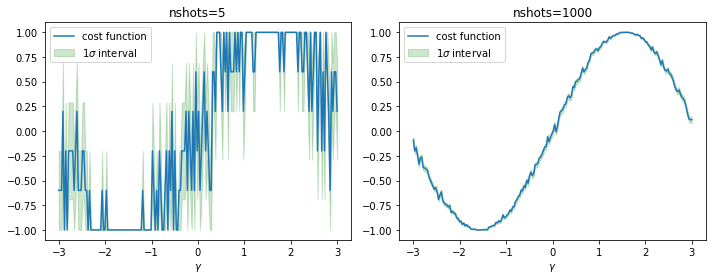

In [15]:
plt.figure(figsize=(10,4))

plt.subplot(121)
plt.plot(gammas, exp_vals1, label="cost function")
plt.fill_between(gammas, exp_vals1 - std_devs1, exp_vals1 + std_devs1,
                 label=r"$1\sigma$ interval", color='g', alpha=0.2)
plt.xlabel(r"$\gamma$")
plt.legend()
plt.title("nshots=5")

plt.subplot(122)
plt.plot(gammas, exp_vals2, label="cost function")
plt.fill_between(gammas, exp_vals2 - std_devs2, exp_vals2 + std_devs2,
                 label=r"$1\sigma$ interval",color='g', alpha=0.2)
plt.title("nshots=1000")
plt.xlabel(r"$\gamma$")
plt.legend()

plt.tight_layout()

Evidently, this time there are no values outside of the range [-1,1], as would also be the case on a real QPU. Furthermore, the plot in the right panel for `nshots=5` looks considerably different from the one earlier with simulated sampling noise. The left plot for `nshots=1000`, on the other hand, looks very similar to the `nshots=1000` plot with the simulated sampling noise. This shows again that our simulated sampling noise works well for larger sample numbers.

 <a id='other_optimisers'></a>
 
## Using other optimisers

In the above examples, we have used `scipy.optimize.minimize` as our optimiser, with COYBLA as the specific method. Even within this Scipy package there are several different methods we could choose - for the full list, see [here](https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.minimize.html). Alternatively, we could use a completely different optimisation package.

Let's redo the above example using some different methods, comparing the performance and time taken of each. Here we'll use the explicit calculation of the expected energy value.

In [16]:
import time

# create the cost_function with our ansatz and hamiltonian:
cost_fun = PrepareAndMeasureOnWFSim(prepare_ansatz=prepare_ansatz,
                                    make_memory_map=lambda p: {"params": p},
                                    hamiltonian=hamiltonian,
                                    nshots = 0, # exact calculution of energy
                                    scalar_cost_function = True,
                                    enable_logging = True)

# the initial value
gamma0 = [0]

In [17]:
methods = ['Nelder-Mead', 'SLSQP', 'Cobyla']

for method in methods:
    initial_time = time.time()
    
    # minimization
    out = minimize(cost_fun, gamma0, method=method)
    
    final_time = time.time()
    
    total_time = final_time - initial_time 
    
    print('Method: ', method)
    print('Time taken: ', total_time)
    print('Result:')
    print(out)
    print('\n')

Method:  Nelder-Mead
Time taken:  0.16504526138305664
Result:
 final_simplex: (array([[-1.5708125],
       [-1.57075  ]]), array([-1., -1.]))
           fun: -0.9999999998692137
       message: 'Optimization terminated successfully.'
          nfev: 52
           nit: 26
        status: 0
       success: True
             x: array([-1.5708125])


Method:  SLSQP
Time taken:  0.029027700424194336
Result:
     fun: -0.9999999984694352
     jac: array([-5.53205609e-05])
 message: 'Optimization terminated successfully.'
    nfev: 10
     nit: 3
    njev: 3
  status: 0
 success: True
       x: array([-1.57085165])


Method:  Cobyla
Time taken:  0.06922435760498047
Result:
     fun: -0.9999999954355244
   maxcv: 0.0
 message: 'Optimization terminated successfully.'
    nfev: 24
  status: 1
 success: True
       x: array([-1.57070078])




Clearly, all three tested optimisers found the same minimum. However, it took Nelder-Mead 52 function evaluations for convergence, while COBYLA and SLSQP needed only 10 and 24 function evaluations, respectively. The latter two therefore seem to be superior. 

However, it is important to note that we set `nshots=0`, meaning that the exact expectation value is returned by the cost function. If we had set `nshots` to some finite value, SLSQP would have had a much harder time, because it is a gradient-based algorithm: it decides where to move in the next step by computing the gradient using finite differences. To work effectively, this requires exact values of the cost function, which is not possible when taking samples (unless, of course, an infinite number of samples is taken). 
 
We can also use a different optimisation library altogether. Here we demonstrate a Bayesian optimisation function from `scikit-optimize` (docs [here](https://scikit-optimize.github.io/#skopt.gp_minimize)). 

**Note that to run the cell below you will need to install scikit-optimize.**

In [28]:
from skopt import gp_minimize
import math

initial_time = time.time()

out = gp_minimize(cost_fun,
                  n_calls=15,
                  dimensions=[(0, 2*math.pi)],
                  x0=gamma0)

final_time = time.time()

total_time = final_time - initial_time 

print('Method: ', 'Bayesian Optimisation')
print('Time taken: ', total_time)
print('Result:')
print(out)
print('\n')

Method:  Bayesian Optimisation
Time taken:  0.9499242305755615
Result:
          fun: -0.9999951032029182
    func_vals: array([ 0.        , -0.10881609,  0.95360189,  0.41721697, -0.98896448,
       -0.99803173,  0.93563543, -0.97851649, -0.00964807, -0.41018182,
       -0.72190887, -0.9999951 , -0.99999503, -0.99998915, -0.99999488])
       models: [GaussianProcessRegressor(alpha=1e-10, copy_X_train=True,
                         kernel=1**2 * Matern(length_scale=1, nu=2.5) + WhiteKernel(noise_level=1),
                         n_restarts_optimizer=2, noise='gaussian',
                         normalize_y=True, optimizer='fmin_l_bfgs_b',
                         random_state=612601979), GaussianProcessRegressor(alpha=1e-10, copy_X_train=True,
                         kernel=1**2 * Matern(length_scale=1, nu=2.5) + WhiteKernel(noise_level=1),
                         n_restarts_optimizer=2, noise='gaussian',
                         normalize_y=True, optimizer='fmin_l_bfgs_b',
        

The usage of Bayesian optimisation to solve this very simple problem is slightly overkill. However, for VQE or QAOA problems where the cost function evaluations themselves are expensive, and the parameter space itself is not too large, Bayesian optimisation may be worth investigating. A good primer can be found [here](https://arxiv.org/pdf/1807.02811.pdf).

<a id='towards_qaoa'></a>

## Towards QAOA

A more detailled explanation of our QAOA library can be found in the Notebooks `1_AnExampleWorkflow.ipynb`,  `2_ParameterClasses.ipynb`, and `3_AdvancedParameterClasses.ipynb`. Here we simply explain how it can be regarded as a special case of VQE.

For QAOA - which was originally designed for solving classical optimization problems - the Hamiltonian is diagonal in the computational basis, and typically contains at most 2-qubit terms (there is nothing to prevent one from considering k-qubit terms, however the limitations of near-term hardware make the k = 2 case the most practically feasible). 

Let's set up a simple Hamiltonian.

In [19]:
hamiltonian = []
hamiltonian.append(PauliTerm("Z", 0, -1)*PauliTerm("Z", 1))
hamiltonian.append(PauliTerm("Z", 0, 0.8))
hamiltonian.append(PauliTerm("Z", 1, -0.5))
hamiltonian = PauliSum(hamiltonian)
print(hamiltonian)

(-1+0j)*Z0*Z1 + (0.8+0j)*Z0 + (-0.5+0j)*Z1


Since the parameters for a QAOA circuit have more structure than just a flat array, and there exist multiple possible parametrisations, we provide special classes to hold the parameters for a QAOA circuit. We will use the `FourierParams` class here. We can create these initial parameters as follows:

In [20]:
params = FourierParams.linear_ramp_from_hamiltonian(hamiltonian, n_steps=5, q=3)

The QAOA cost function has a fixed structure, with a corresponding fixed state preparation program. We therefore provide special cost functions for QAOA, which inherit most of the behaviour from `vqe.cost_functions.PrepareAndMeasure...`. They are created via

In [21]:
qaoa_cost_fun = QAOACostFunctionOnWFSim(hamiltonian,
                                        params,
                                        nshots=1000,
                                        enable_logging=True)

Unlike for `PrepareAndMeasureOnWFSim`, we didn't have to pass a state preparation circuit `prepare_ansatz` or function to generate memory maps `make_memory_map` to `QAOACostFunctionOnWFSim`. These are already fixed by the fact that we want to run QAOA with a given cost Hamiltonian. Instead, we have to pass the QAOA parameters `params` to the cost function.

If we want to find the optimal parameters, we have to provide our optimiser with some initial parameter set. The object `params` contains information on both the problem hyperparameters, as well as the variable parameters to be optimised - see `2_ParameterClasses.ipynb` for further information.

In [22]:
params

Hyperparameters:
	register: [0, 1]
	qubits_singles[0, 1]
	qubits_pairs[[0, 1]]
Parameters:
	v: [0.35 0.   0.  ]
	u: [0.35 0.   0.  ]

We can obtain a 1D array with all of our variable parameters - here denoted `u` and `v` - using the `params.raw()` method: we can subsequently pass these to an optimiser, such as a method from `scipy.optimize.minimize`:

In [23]:
p0 = params.raw()
out = minimize(qaoa_cost_fun, p0, tol=1e-3, method="Cobyla", options={"maxiter": 500})

print("The output of scipy.optimize.minimize:\n",out)
print("\n And hamiltonian as a matrix:\n", lifted_pauli(hamiltonian, hamiltonian.get_qubits()))

The output of scipy.optimize.minimize:
      fun: -1.0980860380605737
   maxcv: 0.0
 message: 'Optimization terminated successfully.'
    nfev: 53
  status: 1
 success: True
       x: array([ 0.33338502, -0.0362319 , -0.00113797,  0.44507301, -0.11073208,
       -0.02014963])

 And hamiltonian as a matrix:
 [[-0.7+0.j  0. +0.j  0. +0.j  0. +0.j]
 [ 0. +0.j -0.3+0.j  0. +0.j  0. +0.j]
 [ 0. +0.j  0. +0.j  2.3+0.j  0. +0.j]
 [ 0. +0.j  0. +0.j  0. +0.j -1.3+0.j]]


Examining the logs this time involves a little extra work. The logging functionality simply appends the array of current parameters (i.e. at any step in the optimisation) to the log. For instance, the 10th log entry reads:

In [24]:
qaoa_cost_fun.log[9]

LogEntry(x=array([ 0.57769948, -0.06151086, -0.05447635,  0.29858683, -0.0309951 ,
       -0.01725329]), fun=(-0.6538453689892179, 0.027969997721439686))

The `LogEntry` array contains the `u` and `v` parameters for all three values of the Fourier parameter `q`. Meanwhile, the `fun` entry is of the form (function value, standard deviation).

To disentangle the `u` and `v` parameters, we can pipe them through the `params` instance again, using the method `.update_from_raw()`:

In [25]:
# logs of the parameter values
u_log = []
v_log = []
for step in qaoa_cost_fun.log:
    params.update_from_raw(step.x)
    u_log.append(params.u)
    v_log.append(params.v)

# create arrays from the lists    
u_log = np.array(u_log)
v_log = np.array(v_log)

# log of the function values
fun_log = np.array([step.fun for step in qaoa_cost_fun.log])

# create an array for the x-axis:
x = np.arange(out["nfev"])

Now we can plot the information in the log:

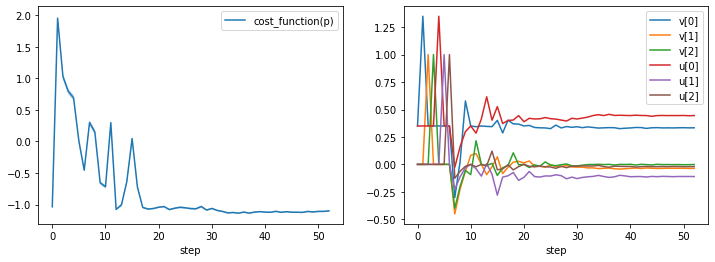

In [26]:
fig, ax = plt.subplots(1,2, figsize=(12,4))
ax[0].plot(x, fun_log[:,0], label="cost_function(p)")
ax[0].fill_between(x, fun_log[:,0] - fun_log[:,1], fun_log[:,0] + fun_log[:,1], alpha=0.3)
ax[0].legend()
ax[0].set_xlabel("step")

for i in range(3):
    ax[1].plot(x, v_log[:,i], label=f"v[{i}]")
for i in range(3):
    ax[1].plot(x, u_log[:,i], label=f"u[{i}]")
ax[1].legend()
ax[1].set_xlabel("step");

We can also plot the final, optimal parameters alone, with the built-in `.params.plot()` function. 

Note: In this case we are working with `Fourier` parameters `u` and `v`, but the actual circuit parameters `betas` and `gammas` are generally those of interest. When we call the `.plot()` function on a set of `Fourier` params, they are automatically converted back to the `betas` and `gammas`.

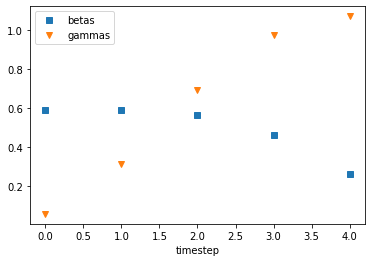

In [27]:
params.update_from_raw(out["x"])
params.plot();

<a id='statistics_details'></a>

## Appendix: Simulated measurement noise - statistics implementation details

The attentive observer will have noticed that when we add simulated measurement noise via the `nshots` option on the Wavefunction Simulator, we sometimes find function values below (above) the minimum (maximum) eigenvalue of the Hamiltonian. As explained above, this is because we "fake" the sampling noise when using the wavefunction-based cost functions `PrepareAndMeasureOnWFSim` and `QAOACostFunctionOnWFSim`. We first calculate the true energy expectation value and variance via

$$
E(\vec{\gamma}) = \left<\psi(\vec{\gamma})\left| \hat{H} \right| \psi(\vec{\gamma})\right>
\qquad\mathrm{and}\qquad
\mathrm{var}(E)(\vec{\gamma}) = \left<\psi(\vec{\gamma})\left| \hat{H}^2 \right| \psi(\vec{\gamma})\right> - \left<\psi(\vec{\gamma})\left| \hat{H} \right| \psi(\vec{\gamma})\right>^2
$$

and then return, in accordance with the [central limit theorem](https://en.wikipedia.org/wiki/Central_limit_theorem), this energy expectation value plus appropriately scaled Gaussian noise, along with the standard deviation of the mean:

$$
\mathrm{cost\_function} (\vec{\gamma}) =
\left(
    E(\vec{\gamma}) +  \mathcal{N}\left(0, \sqrt{\frac{\mathrm{var}(E)(\vec{\gamma})}{\mathrm{nshots}}}\right),
\sqrt{\frac{\mathrm{var}(E)(\vec{\gamma})}{\mathrm{nshots}}}
\right)
$$

Now in some examples above, for the purposes of illustrating the limitations of this method, we used extremely small numbers of shots $\leq 10$. For such small values of `nshots`, the central limit theorem does not hold, and we get the afore mentioned unphysical results on occasion. In practice, in a real VQE or QAOA run, one would in any case take much larger numbers of shots.

On the other hand, the sampling-based cost functions `PrepareAndMeasureOnQVM` and `QAOACostFunctionOnQVM` don't need to 'fake' the sampling noise, and we are guaranteed to get physical results. This comes at the cost of much slower simulations, since many random numbers have to be generated.